
_This supervised learning model will predict good loans versus the bad loans.  The good loans are loan_status = Fully Paid. The bad loans are the loans with a 'loan_status' = Charged Off, Late (31-120 days) and Default.

# Tuning RFC and XGB
 

In [34]:
import warnings
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn.pipeline import Pipeline
#from sklearn.pipeline import make_pipeline
sns.set(style="darkgrid")


warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('lending_club_le.csv', index_col=0)
y = df['good_loan_status']
X = df.drop(['good_loan_status'], axis=1)

In [3]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [4]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70338, 45), (70338,), (17585, 45), (17585,))

# Random Forest tuning
I am tuning the following features and I will apply adaboost to the tuned model. The model will run a 3 fold cross validation.

    - 'max_depth'
    - 'min_samples_leaf'
    - 'n_estimators'
    - 'max_features'
    - 'min_samples_split'

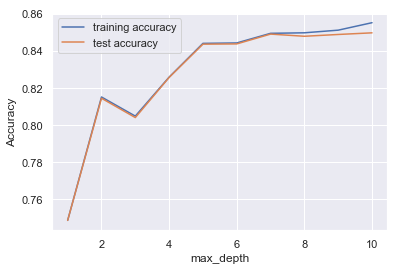

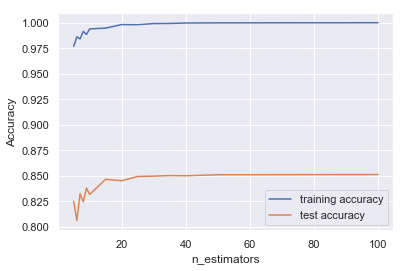

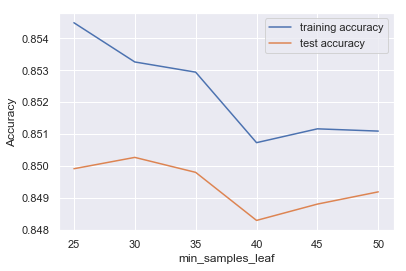

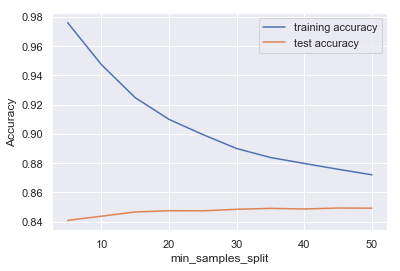

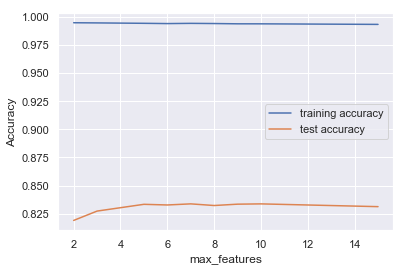

--- 336.0591 seconds --- 


In [12]:
# parameters to build the model on

start_time = time.time()

hyperparameter = ['max_depth',
                  'n_estimators',
                  'min_samples_leaf',
                  'min_samples_split',
                  'max_features']

range = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 50, 100],
    [25, 30, 35, 40, 45, 50],
    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    [2, 3, 5, 6, 7, 8, 9, 10, 15]
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    rf = ensemble.RandomForestClassifier()

    # fit tree on training data
    rfgrid = GridSearchCV(rf, parameters,
                          cv=3,
                          scoring="accuracy")
    rfgrid.fit(X_train, y_train)
    scores = rfgrid.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___Using the parameters above to fine tune to find the best model___

In [14]:
# Create the parameter grid based on the results of random search

param_grid = {
    'max_depth': [2, 4, 6, 8],
    'n_estimators': [20, 80, 100],
    'min_samples_leaf': [45, 50, 55],
    'min_samples_split': [50, 60, 70, 80],
    'max_features': [6, 8, 10]
}
# Create a based model
rf_tree = ensemble.RandomForestClassifier()
# Instantiate the grid search model
rfgrid_search = GridSearchCV(estimator=rf_tree,
                             param_grid=param_grid,
                             cv=3, n_jobs=-1, verbose=1)

In [15]:
# Fit the grid search to the data
start_time = time.time()
rfgrid_search.fit(X_train, y_train)

stop = timeit.default_timer()
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 38.3min finished


--- 2299.7921 seconds --- 


In [16]:
# printing the optimal accuracy score and hyperparameters
print('The best RFC accuracy score is {0:.4f}'.format(
    rfgrid_search.best_score_),
    'and has the parameters\n', rfgrid_search.best_params_)

The best RFC accuracy score is 0.8497 and has the parameters
 {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 45, 'min_samples_split': 80, 'n_estimators': 20}


In [17]:
# model with the best hyperparameters
rf_final = ensemble.RandomForestClassifier(bootstrap=True,
                                           max_depth=8,
                                           max_features=10,
                                           min_samples_leaf=45,
                                           min_samples_split=80,
                                           n_estimators=20)

Tuned RFC has an accuracy score of __84.97%__

------ 

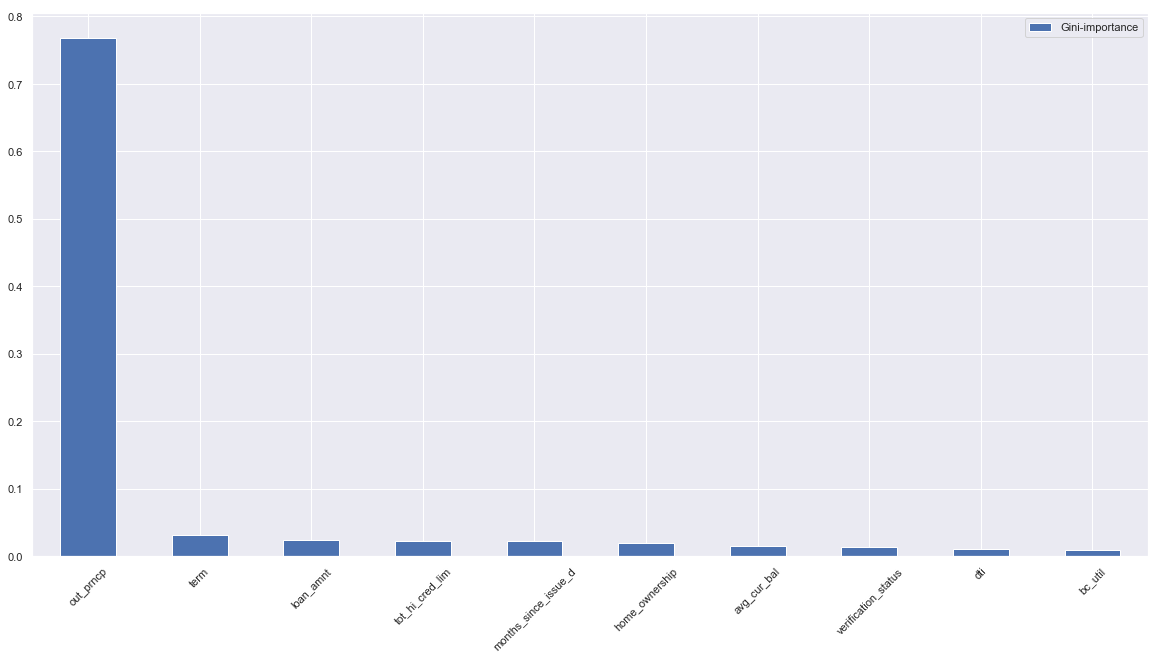

In [18]:
feats = {}  # a dict to hold feature_name: feature_importance
rf_final.fit(X_train, y_train)
for feature, importance in zip(X.columns, rf_final.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',
                        ascending=False).head(10).plot(kind='bar',
                                                       rot=45,
                                                       figsize=(20, 10))

The top 10 features to be used in unsupervised clustering

In [19]:
importances.sort_values(by='Gini-importance',
                        ascending=False).head(10)

,Gini-importance
out_prncp,0.767358
term,0.031246
loan_amnt,0.024437
tot_hi_cred_lim,0.023261
months_since_issue_d,0.022731
home_ownership,0.019996
avg_cur_bal,0.014453
verification_status,0.013375
dti,0.010781
bc_util,0.009650


-----

# Applying the AdaBoostClassifier to Random Forest

In [20]:
# adaboost with the RF tree as base estimator
start_time = time.time()
estimators = np.arange(1, 20, 1)

ada_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(base_estimator=rf_final,
                             n_estimators=n_est)

    res = cross_val_score(ABC,
                          X_train,
                          y_train,
                          cv=3)

    print("\nThe average accuracy score: {0:.4f}".format(np.mean(res)), n_est)
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))


The average accuracy score: 0.8493 1

The average accuracy score: 0.8506 2

The average accuracy score: 0.8514 3

The average accuracy score: 0.8516 4

The average accuracy score: 0.8520 5

The average accuracy score: 0.8520 6

The average accuracy score: 0.8531 7

The average accuracy score: 0.8520 8

The average accuracy score: 0.8517 9

The average accuracy score: 0.8526 10

The average accuracy score: 0.8521 11

The average accuracy score: 0.8521 12

The average accuracy score: 0.8524 13

The average accuracy score: 0.8521 14

The average accuracy score: 0.8525 15

The average accuracy score: 0.8520 16

The average accuracy score: 0.8516 17

The average accuracy score: 0.8522 18

The average accuracy score: 0.8516 19
--- 1062.1757 seconds --- 


In [22]:
ada_final = AdaBoostClassifier(base_estimator=rf_final,
                               n_estimators=7)

With ADAboost RaandomForest (n_estimator = 7) has an accuracy score: ___85.31%___, this is a ___0.34%___ improvement from the RFC model score of ___84.97%___.

------ 

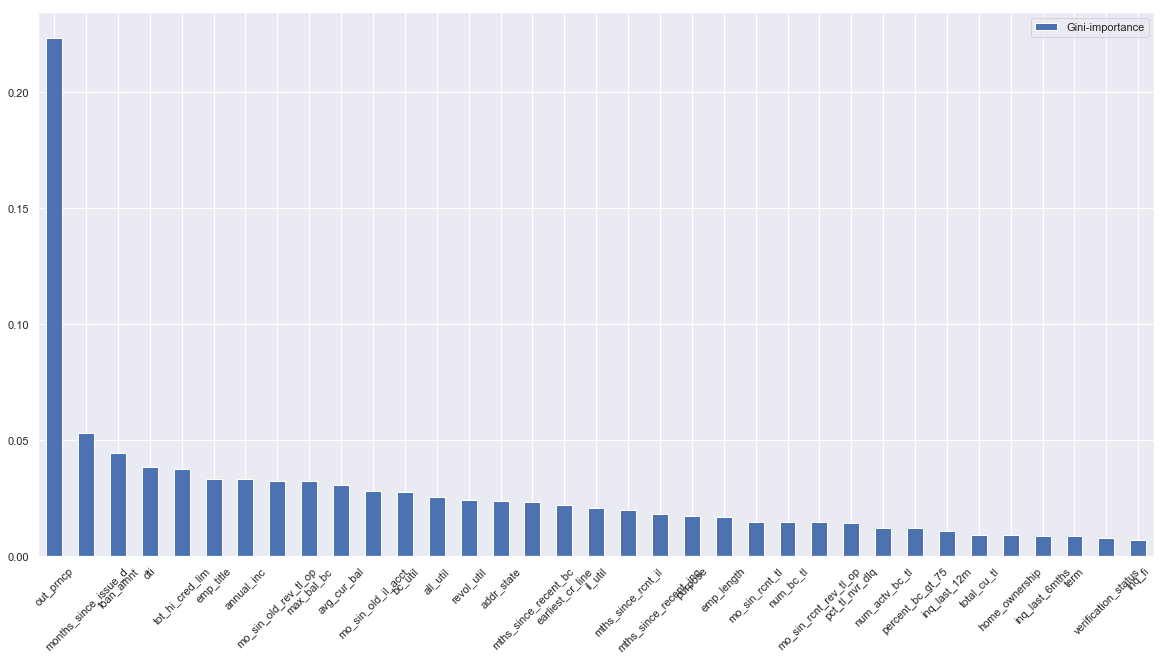

In [23]:
feats = {}  # a dict to hold feature_name: feature_importance
ada_final.fit(X_train, y_train)
for feature, importance in zip(X.columns, ada_final.feature_importances_):
    feats[feature] = importance

ada_importances = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
ada_importances.sort_values(by='Gini-importance',
                            ascending=False).head(35).plot(kind='bar',
                                                           rot=45,
                                                           figsize=(20, 10))

In [24]:
importances.sort_values(by='Gini-importance',
                        ascending=False).head(10)

,Gini-importance
out_prncp,0.767358
term,0.031246
loan_amnt,0.024437
tot_hi_cred_lim,0.023261
months_since_issue_d,0.022731
home_ownership,0.019996
avg_cur_bal,0.014453
verification_status,0.013375
dti,0.010781
bc_util,0.009650


_Feature importance of the boosted Random Forest.  Past medical expenses and open accounts are big factors in getting approved for a loan._

-------------

# Extreme Gradiant Boosting Tuning

I am tuning the following features to get the best score
    - 'max_depth'
    - 'learning_rate'
    - 'n_estimators'
    - 'subsample'
    - 'colsample_bytree'
    - 'colsample_bylevel'

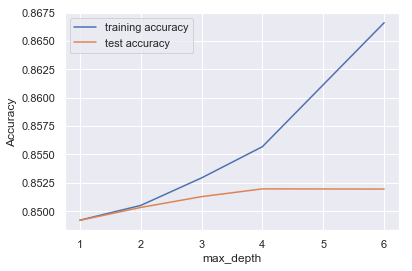

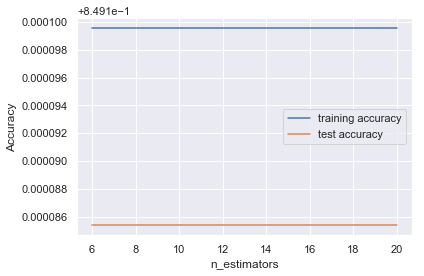

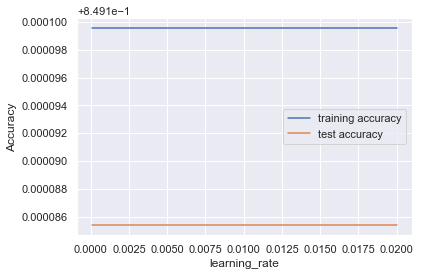

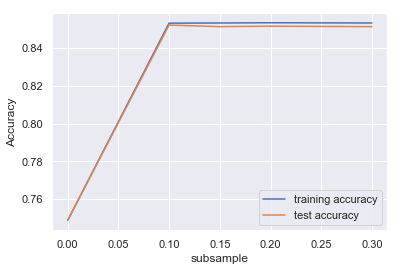

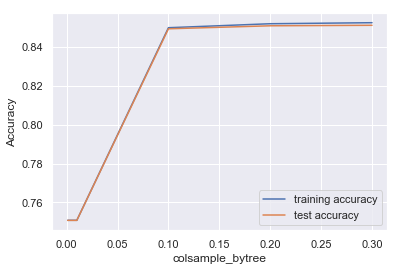

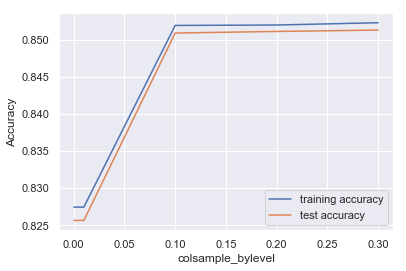

--- 740.6223 seconds --- 


In [27]:
start_time = time.time()


# parameters to build the model on
hyperparameter = ['max_depth',
                  'n_estimators',
                  'learning_rate',
                  'subsample',
                  'colsample_bytree',
                  'colsample_bylevel']

range = [
    [1, 2, 3, 4, 6],
    [6, 7, 10, 20],
    [0.0001, 0.001, 0.01, 0.02],
    [0.0001, 0.1, 0.15, 0.2, 0.3],
    [0.001, 0.01, 0.1, 0.2, 0.3],
    [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    XGB = XGBClassifier()

    # fit tree on training data
    XGB = GridSearchCV(XGB, parameters,
                       cv=3,
                       scoring="accuracy")  # you can change scoring functions right here.
    XGB.fit(X_train, y_train)
    scores = XGB.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___now let's plug in the values to get the final parameters___

In [28]:
param_grid = {
    'max_depth': [1, 2, 3],
    'n_estimators': [2, 4, 5],
    'learning_rate': [0.001, 0.01, 0.05],
    'subsample': [0.0001, 0.001, 0.01],
    'colsample_bytree': [0.001, 0.01, 0.1],
    'colsample_bylevel': [0.001, 0.01, 0.05], }
# Create a based model
xgb = XGBClassifier()
# Instantiate the grid search model
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                        cv=3, n_jobs=-1, verbose=1)

In [29]:
# Fit the grid search to the data
start_time = time.time()
xgb_grid.fit(X_train, y_train)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed: 10.1min finished


--- 607.7127 seconds --- 


In [30]:
# printing the optimal accuracy score and hyperparameters
print('The best XGB accuracy score is {0:.4f}'.format(
    xgb_grid.best_score_), 'with parameters\n', xgb_grid.best_params_)

The best XGB accuracy score is 0.7569 with parameters
 {'colsample_bylevel': 0.001, 'colsample_bytree': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 4, 'subsample': 0.001}


In [31]:
xgb_param_grid = {
    'max_depth': [3],
    'n_estimators': [4],
    'learning_rate': [0.05],
    'subsample': [0.001],
    'colsample_bytree': [0.1],
    'colsample_bylevel': [0.001]}
xgb_final = XGBClassifier()

xgb_grid_f = GridSearchCV(estimator=xgb_final, param_grid=xgb_param_grid,
                          cv=3, n_jobs=-1, verbose=1)
xgb_grid_f.fit(X_train, y_train)
print('We can get accuracy of {0:.4f}'.format(
    xgb_grid_f.best_score_), 'with parameters\n', xgb_grid_f.best_params_)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


We can get accuracy of 0.7569 with parameters
 {'colsample_bylevel': 0.001, 'colsample_bytree': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 4, 'subsample': 0.001}
--- 831.4767 seconds --- 


_The accuracy score for Extreme Gradient Boost:_ ___75.69%___

In [32]:
xgb.fit(X_train, y_train)
xgb_fea_imp = pd.DataFrame(list(xgb.get_booster().get_fscore().items()),
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)
print('', xgb_fea_imp)

                        feature  importance
1         months_since_issue_d          58
0                    out_prncp          53
5                    loan_amnt          50
3              tot_hi_cred_lim          42
7                          dti          37
8                      bc_util          26
15                     purpose          19
2                         term          17
17                    all_util          16
6               home_ownership          16
10       mths_since_recent_inq          15
23          mo_sin_old_il_acct          14
22          mths_since_rcnt_il          14
11                  emp_length          13
13                  max_bal_bc          13
16                  annual_inc          13
4          verification_status          13
12              inq_last_6mths          12
14              mo_sin_rcnt_tl          12
19            percent_bc_gt_75          12
20        mo_sin_old_rev_tl_op          11
9                  avg_cur_bal           9
27        

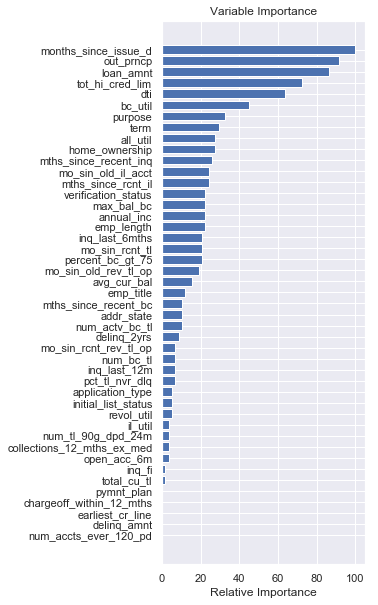

In [33]:
fig = plt.figure(figsize=(8, 10))
feature_importance = xgb.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

-----

Tuning Random forest with ada boost has the best accuracy score.  84.05% of the time it is able to tell whether a long is good or bad. This is beats the baseline (77.37%) by 8.38%.  XGB doesn't beat the baseline. Now I will use the tuned values to compare the accuracy of all the models.  Looking at the features, there are more that can clearly be removed before modeling as they don't add value to the model.

_With ADAboost RaandomForest (n_estimator = 18) has an accuracy score: ___84.05%___, this is a ___3.11%___ improvement from the RFC model score of ___80.94___.